In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import interp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.dummy import DummyClassifier

# Load data

In [2]:
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
target_labels = [val for key, val in emotion_labels.items()]
targets = [key for key, val in emotion_labels.items()]

In [3]:
def load_data(df, data_type):
    """Load data from DataFrame and return data to list 
    """
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        if data_type == 1:
            field = row.pca
        elif data_type == 2:
            field = row.histogram
        elif data_type == 3:
            field = row.hog
        elif data_type == 4:
            field = row.lda
        else:
            field = row.pixels
        image = np.fromstring(field, sep=' ')
        image_data.append(image)
        if data_type == 0:
            scale = image / 255.0
            image_scaled.append(scale)
        
    return image_data, image_scaled

# Grid Search with PCA data

Find out the good tuning for hyper parameter with PCA data because it takes long time to get result with original data.

10k train data and 2500 test data are used for this.

In [5]:
df = pd.read_csv('data/pca/fer_pca.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.4589713258466278 0.962093546388383 -0.55788...
1,train,3,0.49198604184990685 -1.0021801630235339 0.2740...
2,train,3,-0.9419501076570959 1.4385249489843621 0.29373...
3,train,3,-1.2800578618783192 0.23932335345423272 0.4704...
4,train,3,0.10681625087574084 -0.7089926999517396 0.3826...


In [6]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, train_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [7]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 103)
(31432,)
(7896, 103)
(7896,)


In [9]:
X_train = X_train[0:10000]
y_train = y_train[0:10000]
X_test = X_test[0:2500]
y_test = y_test[0:2500]

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10000, 103)
(10000,)
(2500, 103)
(2500,)


## Find out which kernel is best

In [ ]:
param_gamma = ['auto', 'scale']
param_grid = [{'kernel': ['linear']},
              {'gamma': param_gamma, 
               'kernel': ['rbf']},
              {'gamma': param_gamma,
               'kernel': ['poly']},
              {'gamma': param_gamma,
               'kernel': ['poly']}]

svm = SVC(random_state=1, decision_function_shape='ovo')

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [ ]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

## Find out which C is best

In [15]:
param_c =  [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [{'C': param_c,
               'gamma': ['auto'],
               'kernel': ['rbf']}]

svm = SVC(random_state=1, decision_function_shape='ovo')

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx

In [16]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

0.788
{'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'}
Test accuracy: 0.790


In [ ]:
svm = SVC(C=10.0, gamma='auto', kernel='rbf', random_state=1, decision_function_shape='ovr')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
print('Test Accuracy: %.3f' % svm.score(X_test, y_test))

Following comparison use RBF kernel, auto gamma, and C as 10. 

# SVM with original dataset

In [40]:
df = pd.read_csv('data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [41]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scale = load_data(df_train, 0)
train_target = list(df_train.emotion)
test_data, test_scale = load_data(df_test, 0)
test_target = list(df_test.emotion)

In [42]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 2304)
(31432,)
(7896, 2304)
(7896,)


In [44]:
svm = SVC(C=10.0, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
print('Test Accuracy: %.3f' % svm.score(X_test, y_test))

Train Accuracy: 0.999
Test Accuracy: 0.388


In [45]:
orig_predictions = [y_pred]
orig_actuals = [y_test]

In [46]:
# Scaled data
X_train = np.array(train_scale)
y_train = np.array(train_target)
X_test = np.array(test_scale)
y_test = np.array(test_target)

In [47]:
svm = SVC(C=10.0, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
print('Test Accuracy: %.3f' % svm.score(X_test, y_test))

Train Accuracy: 0.473
Test Accuracy: 0.435


In [48]:
orig_predictions.append(y_pred)
orig_actuals.append(y_test)

## Evaluation

### Confusion matrix

In [4]:
def show_confusion_matrix(confmat):
    """Display confusion matrix with percent values 
    """
    confmat = confmat/np.sum(confmat) * 100
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            percent = "{:.2f}".format(confmat[i, j])
            ax.text(x=j, y=i, s=percent+'%', va='center', ha='center')


    ax.set_xticklabels([''] + target_labels)
    ax.set_yticklabels([''] + target_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


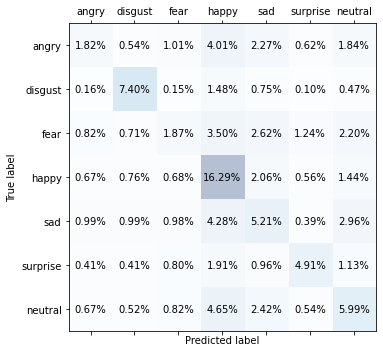

In [59]:
i = 1
confmat = confusion_matrix(y_true=orig_actuals[i], y_pred=orig_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [60]:
i = 0
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

Precision: 0.857
Recall: 0.356
F1: 0.323
Accuracy: 0.388
              precision    recall  f1-score   support

       angry       0.97      0.07      0.12       957
     disgust       1.00      1.00      1.00       830
        fear       0.91      0.09      0.16      1024
       happy       0.27      1.00      0.42      1774
         sad       0.93      0.03      0.06      1247
    surprise       0.99      0.27      0.43       831
     neutral       0.93      0.03      0.07      1233

    accuracy                           0.39      7896
   macro avg       0.86      0.36      0.32      7896
weighted avg       0.80      0.39      0.30      7896



In [61]:
i = 1
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

Precision: 0.430
Recall: 0.415
F1: 0.408
Accuracy: 0.435
              precision    recall  f1-score   support

       angry       0.33      0.15      0.21       957
     disgust       0.65      0.70      0.68       830
        fear       0.30      0.14      0.19      1024
       happy       0.45      0.72      0.56      1774
         sad       0.32      0.33      0.32      1247
    surprise       0.59      0.47      0.52       831
     neutral       0.37      0.38      0.38      1233

    accuracy                           0.43      7896
   macro avg       0.43      0.41      0.41      7896
weighted avg       0.42      0.43      0.41      7896



# SVM with PCA

In [5]:
def processSVM(csv, data_type):
    """Process SVM for each csv data
    """
    print(csv)
    df = pd.read_csv(csv)
    df.head()
    
    df_train = df[df['usage']=='train']
    df_test = df[df['usage']=='test']
    train_data, train_scaled = load_data(df_train, data_type)
    train_target = list(df_train.emotion)
    test_data, test_scaled = load_data(df_test, data_type)
    test_target = list(df_test.emotion)
    
    X_train = np.array(train_data)
    y_train = np.array(train_target)
    X_test = np.array(test_data)
    y_test = np.array(test_target)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    svm = SVC(C=10.0, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print('Train Accuracy: %.3f' % svm.score(X_train, y_train))
    print('Test Accuracy: %.3f' % svm.score(X_test, y_test))
    
    return y_pred, y_test

In [6]:
csv_list = ['data/pca/fer_pca.csv', 'data/pca/fer_pca_inverse.csv', 'data/pca/fer_pca_norm.csv', 
            'data/pca/fer_pca_std.csv', 'data/pca/fer_pca_scaled.csv']

In [7]:
pca_predictions = []
pca_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 1)
    pca_predictions.append(pred)
    pca_actuals.append(act)

data/pca/fer_pca.csv
(31432, 103)
(31432,)
(7896, 103)
(7896,)
Train Accuracy: 0.989
Test Accuracy: 0.536
data/pca/fer_pca_inverse.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.225
data/pca/fer_pca_norm.csv
(31432, 157)
(31432,)
(7896, 157)
(7896,)
Train Accuracy: 0.992
Test Accuracy: 0.533
data/pca/fer_pca_std.csv
(31432, 112)
(31432,)
(7896, 112)
(7896,)
Train Accuracy: 0.991
Test Accuracy: 0.546
data/pca/fer_pca_scaled.csv
(31432, 103)
(31432,)
(7896, 103)
(7896,)
Train Accuracy: 0.989
Test Accuracy: 0.538


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


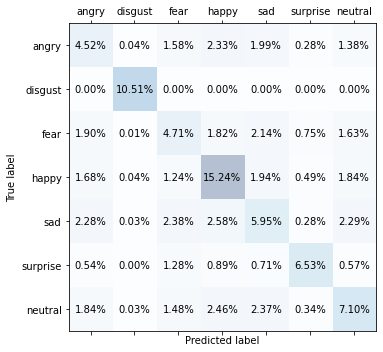

In [49]:
# Show only the best one 
i = 3
confmat = confusion_matrix(y_true=pca_actuals[i], y_pred=pca_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance matrics & Classification reports

In [10]:
def showPerformance(predictions, actuals):
    """Display performance of each result
    """
    for i in range(len(csv_list)):
        print(csv_list[i])
        print('Precision: %.3f' % precision_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Recall: %.3f' % recall_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('F1: %.3f' % f1_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Accuracy: %.3f' % accuracy_score(y_true=actuals[i], y_pred=predictions[i]))
        print('Classification reports')
        print(classification_report(actuals[i], predictions[i], target_names=list(target_labels)))

In [11]:
showPerformance(pca_predictions, pca_actuals)

data/pca/fer_pca.csv
Precision: 0.553
Recall: 0.544
F1: 0.547
Accuracy: 0.536
Classification reports
              precision    recall  f1-score   support

       angry       0.34      0.36      0.35       957
     disgust       0.97      1.00      0.99       830
        fear       0.38      0.36      0.37      1024
       happy       0.60      0.66      0.62      1774
         sad       0.39      0.37      0.38      1247
    surprise       0.74      0.62      0.68       831
     neutral       0.45      0.44      0.45      1233

    accuracy                           0.54      7896
   macro avg       0.55      0.54      0.55      7896
weighted avg       0.54      0.54      0.54      7896

data/pca/fer_pca_inverse.csv
Precision: 0.032
Recall: 0.143
F1: 0.052
Accuracy: 0.225
Classification reports
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       957
     disgust       0.00      0.00      0.00       830
        fear       0.00      0

C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_clas

# SVM with FisherFace

In [12]:
csv_list = ['data/lda/fer_lda.csv', 'data/lda/fer_lda_norm.csv', 'data/lda/fer_lda_std.csv', 'data/lda/fer_lda_scaled.csv']

In [13]:
lda_predictions = []
lda_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 4)
    lda_predictions.append(pred)
    lda_actuals.append(act)

data/lda/fer_lda.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.443
Test Accuracy: 0.398
data/lda/fer_lda_norm.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.447
Test Accuracy: 0.388
data/lda/fer_lda_std.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.450
Test Accuracy: 0.402
data/lda/fer_lda_scaled.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.444
Test Accuracy: 0.399


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


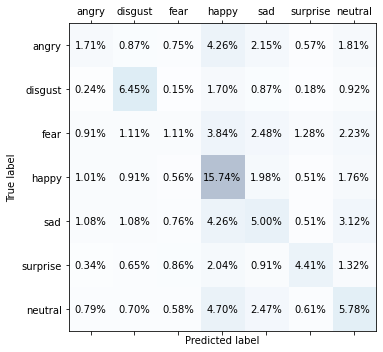

In [50]:
# Show only the best one 
i = 2
confmat = confusion_matrix(y_true=lda_actuals[i], y_pred=lda_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [15]:
showPerformance(lda_predictions, lda_actuals)

data/lda/fer_lda.csv
Precision: 0.382
Recall: 0.375
F1: 0.365
Accuracy: 0.398
Classification reports
              precision    recall  f1-score   support

       angry       0.26      0.13      0.17       957
     disgust       0.56      0.61      0.59       830
        fear       0.23      0.09      0.13      1024
       happy       0.43      0.68      0.53      1774
         sad       0.30      0.32      0.31      1247
    surprise       0.55      0.43      0.48       831
     neutral       0.33      0.36      0.34      1233

    accuracy                           0.40      7896
   macro avg       0.38      0.38      0.36      7896
weighted avg       0.38      0.40      0.37      7896

data/lda/fer_lda_norm.csv
Precision: 0.371
Recall: 0.366
F1: 0.357
Accuracy: 0.388
Classification reports
              precision    recall  f1-score   support

       angry       0.27      0.16      0.20       957
     disgust       0.54      0.62      0.58       830
        fear       0.23      0.10

# SVM with SIFT

In [16]:
csv_list = ['data/sift/sift_bof_100.csv', 'data/sift/sift_bof_500.csv', 'data/sift/sift_bof_1000.csv', 
            'data/sift/sift_pca_bof_100.csv', 'data/sift/sift_pca_bof_500.csv', 'data/sift/sift_pca_bof_1000.csv']

In [17]:
sift_predictions = []
sift_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    sift_predictions.append(pred)
    sift_actuals.append(act)

data/sift/sift_bof_100.csv
(31427, 99)
(31427,)
(7895, 99)
(7895,)
Train Accuracy: 0.654
Test Accuracy: 0.172
data/sift/sift_bof_500.csv
(31427, 499)
(31427,)
(7895, 499)
(7895,)
Train Accuracy: 0.407
Test Accuracy: 0.183
data/sift/sift_bof_1000.csv
(31427, 999)
(31427,)
(7895, 999)
(7895,)
Train Accuracy: 0.443
Test Accuracy: 0.168
data/sift/sift_pca_bof_100.csv
(31425, 99)
(31425,)
(7894, 99)
(7894,)
Train Accuracy: 0.526
Test Accuracy: 0.190
data/sift/sift_pca_bof_500.csv
(31425, 499)
(31425,)
(7894, 499)
(7894,)
Train Accuracy: 0.366
Test Accuracy: 0.192
data/sift/sift_pca_bof_1000.csv
(31425, 999)
(31425,)
(7894, 999)
(7894,)
Train Accuracy: 0.397
Test Accuracy: 0.190


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


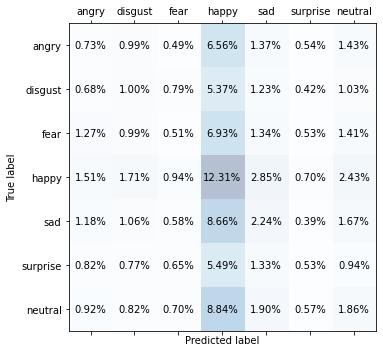

In [51]:
# Show only the best one 
i = 4
confmat = confusion_matrix(y_true=sift_actuals[i], y_pred=sift_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [19]:
showPerformance(sift_predictions, sift_actuals)

data/sift/sift_bof_100.csv
Precision: 0.129
Recall: 0.139
F1: 0.125
Accuracy: 0.172
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.12      0.13       957
     disgust       0.05      0.00      0.01       830
        fear       0.10      0.06      0.08      1024
       happy       0.22      0.41      0.29      1773
         sad       0.17      0.17      0.17      1247
    surprise       0.08      0.04      0.05       831
     neutral       0.15      0.15      0.15      1233

    accuracy                           0.17      7895
   macro avg       0.13      0.14      0.13      7895
weighted avg       0.14      0.17      0.15      7895

data/sift/sift_bof_500.csv
Precision: 0.159
Recall: 0.152
F1: 0.144
Accuracy: 0.183
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.09      0.11       957
     disgust       0.13      0.11      0.12       830
        fear       0.14   

# SVM with KAZE

In [20]:
csv_list = ['data/kaze/kaze_bof_100.csv', 'data/kaze/kaze_bof_500.csv', 'data/kaze/kaze_bof_1000.csv', 
            'data/kaze/kaze_pca_bof_100.csv', 'data/kaze/kaze_pca_bof_500.csv', 'data/kaze/kaze_pca_bof_1000.csv']

In [21]:
kaze_predictions = []
kaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    kaze_predictions.append(pred)
    kaze_actuals.append(act)

data/kaze/kaze_bof_100.csv
(31284, 99)
(31284,)
(7856, 99)
(7856,)
Train Accuracy: 0.538
Test Accuracy: 0.183
data/kaze/kaze_bof_500.csv
(31284, 499)
(31284,)
(7856, 499)
(7856,)
Train Accuracy: 0.347
Test Accuracy: 0.192
data/kaze/kaze_bof_1000.csv
(31284, 999)
(31284,)
(7856, 999)
(7856,)
Train Accuracy: 0.363
Test Accuracy: 0.204
data/kaze/kaze_pca_bof_100.csv
(31275, 99)
(31275,)
(7853, 99)
(7853,)
Train Accuracy: 0.524
Test Accuracy: 0.193
data/kaze/kaze_pca_bof_500.csv
(31275, 499)
(31275,)
(7853, 499)
(7853,)
Train Accuracy: 0.319
Test Accuracy: 0.204
data/kaze/kaze_pca_bof_1000.csv
(31275, 999)
(31275,)
(7853, 999)
(7853,)
Train Accuracy: 0.345
Test Accuracy: 0.206


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


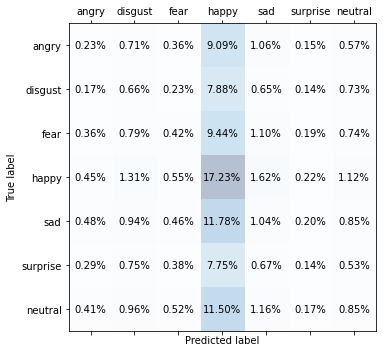

In [22]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=kaze_actuals[i], y_pred=kaze_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [23]:
showPerformance(kaze_predictions, kaze_actuals)

data/kaze/kaze_bof_100.csv
Precision: 0.145
Recall: 0.140
F1: 0.122
Accuracy: 0.183
Classification reports
              precision    recall  f1-score   support

       angry       0.13      0.06      0.08       955
     disgust       0.15      0.03      0.05       821
        fear       0.13      0.09      0.10      1022
       happy       0.22      0.55      0.32      1770
         sad       0.15      0.09      0.11      1237
    surprise       0.09      0.05      0.06       828
     neutral       0.14      0.13      0.13      1223

    accuracy                           0.18      7856
   macro avg       0.15      0.14      0.12      7856
weighted avg       0.15      0.18      0.14      7856

data/kaze/kaze_bof_500.csv
Precision: 0.134
Recall: 0.141
F1: 0.109
Accuracy: 0.192
Classification reports
              precision    recall  f1-score   support

       angry       0.11      0.02      0.03       955
     disgust       0.12      0.10      0.11       821
        fear       0.12   

# SVM with ORB

In [24]:
csv_list = ['data/orb/orb_bof_100.csv', 'data/orb/orb_bof_500.csv', 'data/orb/orb_bof_1000.csv', 
            'data/orb/orb_pca_bof_100.csv', 'data/orb/orb_pca_bof_500.csv', 'data/orb/orb_pca_bof_1000.csv']

In [25]:
orb_predictions = []
orb_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    orb_predictions.append(pred)
    orb_actuals.append(act)

data/orb/orb_bof_100.csv
(31430, 99)
(31430,)
(7896, 99)
(7896,)
Train Accuracy: 0.912
Test Accuracy: 0.165
data/orb/orb_bof_500.csv
(31430, 499)
(31430,)
(7896, 499)
(7896,)
Train Accuracy: 0.444
Test Accuracy: 0.212
data/orb/orb_bof_1000.csv
(31430, 999)
(31430,)
(7896, 999)
(7896,)
Train Accuracy: 0.394
Test Accuracy: 0.202
data/orb/orb_pca_bof_100.csv
(31400, 99)
(31400,)
(7890, 99)
(7890,)
Train Accuracy: 0.791
Test Accuracy: 0.186
data/orb/orb_pca_bof_500.csv
(31400, 499)
(31400,)
(7890, 499)
(7890,)
Train Accuracy: 0.368
Test Accuracy: 0.205
data/orb/orb_pca_bof_1000.csv
(31400, 999)
(31400,)
(7890, 999)
(7890,)
Train Accuracy: 0.347
Test Accuracy: 0.191


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


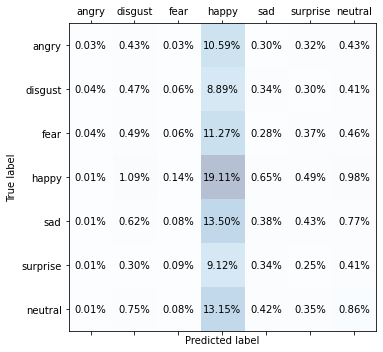

In [53]:
# Show only the best one 
i = 1
confmat = confusion_matrix(y_true=orb_actuals[i], y_pred=orb_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [54]:
showPerformance(orb_predictions, orb_actuals)

data/hog/hog_data2.csv
Precision: 0.131
Recall: 0.140
F1: 0.122
Accuracy: 0.165
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.02      0.04       957
     disgust       0.00      0.00      0.00       830
        fear       0.13      0.11      0.12      1024
       happy       0.24      0.31      0.27      1774
         sad       0.18      0.09      0.12      1247
    surprise       0.08      0.11      0.09       831
     neutral       0.15      0.33      0.21      1233

    accuracy                           0.16      7896
   macro avg       0.13      0.14      0.12      7896
weighted avg       0.15      0.16      0.14      7896

data/hog/hog_scaled2.csv
Precision: 0.152
Recall: 0.144
F1: 0.085
Accuracy: 0.212
Classification reports
              precision    recall  f1-score   support

       angry       0.17      0.00      0.00       957
     disgust       0.11      0.04      0.06       830
        fear       0.12      0.0

# SVM with BRISK

In [28]:
csv_list = ['data/brisk/brisk_bof_100.csv', 'data/brisk/brisk_bof_500.csv', 'data/brisk/brisk_bof_1000.csv', 
            'data/brisk/brisk_pca_bof_100.csv', 'data/brisk/brisk_pca_bof_500.csv', 'data/brisk/brisk_pca_bof_1000.csv']

In [29]:
brisk_predictions = []
brisk_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    brisk_predictions.append(pred)
    brisk_actuals.append(act)

data/brisk/brisk_bof_100.csv
(30833, 99)
(30833,)
(7731, 99)
(7731,)
Train Accuracy: 0.497
Test Accuracy: 0.205
data/brisk/brisk_bof_500.csv
(30833, 499)
(30833,)
(7731, 499)
(7731,)
Train Accuracy: 0.358
Test Accuracy: 0.187
data/brisk/brisk_bof_1000.csv
(30833, 999)
(30833,)
(7731, 999)
(7731,)
Train Accuracy: 0.378
Test Accuracy: 0.198
data/brisk/brisk_pca_bof_100.csv
(8004, 99)
(8004,)
(2160, 99)
(2160,)
Train Accuracy: 0.319
Test Accuracy: 0.186
data/brisk/brisk_pca_bof_500.csv
(8004, 499)
(8004,)
(2160, 499)
(2160,)
Train Accuracy: 0.291
Test Accuracy: 0.192
data/brisk/brisk_pca_bof_1000.csv
(8004, 999)
(8004,)
(2160, 999)
(2160,)
Train Accuracy: 0.254
Test Accuracy: 0.193


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


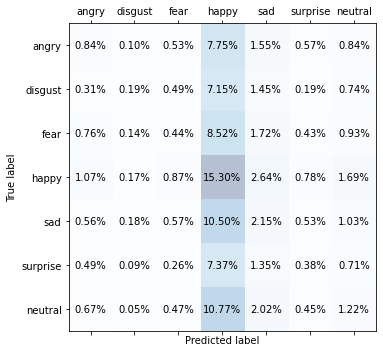

In [55]:
# Show only the best one 
i = 0
confmat = confusion_matrix(y_true=brisk_actuals[i], y_pred=brisk_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [56]:
showPerformance(brisk_predictions, brisk_actuals)

data/hog/hog_data2.csv
Precision: 0.169
Recall: 0.150
F1: 0.120
Accuracy: 0.205
Classification reports
              precision    recall  f1-score   support

       angry       0.18      0.07      0.10       942
     disgust       0.21      0.02      0.03       814
        fear       0.12      0.03      0.05      1001
       happy       0.23      0.68      0.34      1741
         sad       0.17      0.14      0.15      1200
    surprise       0.11      0.04      0.05       823
     neutral       0.17      0.08      0.11      1210

    accuracy                           0.21      7731
   macro avg       0.17      0.15      0.12      7731
weighted avg       0.18      0.21      0.15      7731

data/hog/hog_scaled2.csv
Precision: 0.136
Recall: 0.139
F1: 0.113
Accuracy: 0.187
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.05      0.07       942
     disgust       0.10      0.06      0.07       814
        fear       0.11      0.0

# SVM with AKAZE

In [32]:
csv_list = ['data/akaze/akaze_bof_100.csv', 'data/akaze/akaze_bof_500.csv', 'data/akaze/akaze_bof_1000.csv', 
            'data/akaze/akaze_pca_bof_100.csv', 'data/akaze/akaze_pca_bof_500.csv', 'data/akaze/akaze_pca_bof_1000.csv']

In [33]:
akaze_predictions = []
akaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 2)
    akaze_predictions.append(pred)
    akaze_actuals.append(act)

data/akaze/akaze_bof_100.csv
(31332, 99)
(31332,)
(7862, 99)
(7862,)
Train Accuracy: 0.727
Test Accuracy: 0.185
data/akaze/akaze_bof_500.csv
(31332, 499)
(31332,)
(7862, 499)
(7862,)
Train Accuracy: 0.447
Test Accuracy: 0.187
data/akaze/akaze_bof_1000.csv
(31332, 999)
(31332,)
(7862, 999)
(7862,)
Train Accuracy: 0.452
Test Accuracy: 0.189
data/akaze/akaze_pca_bof_100.csv
(25314, 99)
(25314,)
(6606, 99)
(6606,)
Train Accuracy: 0.361
Test Accuracy: 0.212
data/akaze/akaze_pca_bof_500.csv
(25314, 499)
(25314,)
(6606, 499)
(6606,)
Train Accuracy: 0.301
Test Accuracy: 0.211
data/akaze/akaze_pca_bof_1000.csv
(25314, 999)
(25314,)
(6606, 999)
(6606,)
Train Accuracy: 0.300
Test Accuracy: 0.214


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


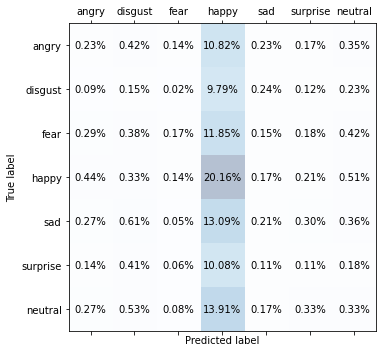

In [57]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=akaze_actuals[i], y_pred=akaze_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [58]:
showPerformance(akaze_predictions, akaze_actuals)

data/hog/hog_data2.csv
Precision: 0.141
Recall: 0.151
F1: 0.136
Accuracy: 0.185
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.11      0.12       954
     disgust       0.06      0.00      0.01       822
        fear       0.14      0.09      0.11      1022
       happy       0.23      0.42      0.30      1766
         sad       0.19      0.26      0.22      1237
    surprise       0.08      0.03      0.05       831
     neutral       0.14      0.13      0.14      1230

    accuracy                           0.19      7862
   macro avg       0.14      0.15      0.14      7862
weighted avg       0.15      0.19      0.16      7862

data/hog/hog_scaled2.csv
Precision: 0.159
Recall: 0.152
F1: 0.142
Accuracy: 0.187
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.07      0.09       954
     disgust       0.15      0.06      0.09       822
        fear       0.15      0.0

# SVM with HoG

In [36]:
csv_list = ['data/hog/hog_data2.csv', 'data/hog/hog_scaled2.csv']

In [37]:
hog_predictions = []
hog_actuals = []
for i in range(len(csv_list)):
    pred, act = processSVM(csv_list[i], 3)
    hog_predictions.append(pred)
    hog_actuals.append(act)

data/hog/hog_data2.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.405
data/hog/hog_scaled2.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.528
Test Accuracy: 0.470


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_15696\4280984978.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


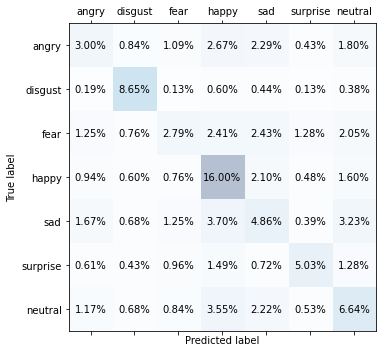

In [38]:
# Show only the best one 
i = 1
confmat = confusion_matrix(y_true=hog_actuals[i], y_pred=hog_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance metrics & Classification reports

In [39]:
showPerformance(hog_predictions, hog_actuals)

data/hog/hog_data2.csv
Precision: 0.816
Recall: 0.374
F1: 0.353
Accuracy: 0.405
Classification reports
              precision    recall  f1-score   support

       angry       0.90      0.08      0.15       957
     disgust       1.00      1.00      1.00       830
        fear       0.88      0.12      0.21      1024
       happy       0.28      1.00      0.43      1774
         sad       0.86      0.06      0.11      1247
    surprise       0.98      0.29      0.45       831
     neutral       0.82      0.06      0.12      1233

    accuracy                           0.40      7896
   macro avg       0.82      0.37      0.35      7896
weighted avg       0.76      0.40      0.33      7896

data/hog/hog_scaled2.csv
Precision: 0.461
Recall: 0.458
F1: 0.452
Accuracy: 0.470
Classification reports
              precision    recall  f1-score   support

       angry       0.34      0.25      0.29       957
     disgust       0.68      0.82      0.75       830
        fear       0.36      0.2

# Benchmark

## Find out best parameter for benchmark

It is done in KNN notebook and most_frequent strategy seems the best.

## Check with Best PCA data

In [62]:
df = pd.read_csv('data/pca/fer_pca_std.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.7174040838712432 -0.7702660905290193 -0.513...
1,train,3,0.7212745110957715 0.8709909412648307 -0.05813...
2,train,3,-1.1415807452074815 -0.9530090924132242 0.6111...
3,train,3,-1.2521535857006059 0.13698174383357514 0.5316...
4,train,3,0.294048049351381 0.832202280005905 0.10490519...


In [63]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [64]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [65]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [66]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with Best LDA data

In [67]:
df = pd.read_csv('data/lda/fer_lda_std.csv')
df.head()

,usage,emotion,lda
0,train,3,0.7894818314647534 0.2147150019296881 -0.87952...
1,train,3,0.6069599043975686 -0.20427589187483838 0.2641...
2,train,3,-0.2795828858633714 1.0125084423693098 -0.1462...
3,train,3,-0.12393359351771732 0.4088989785758754 -1.315...
4,train,3,-0.14131908024016165 1.0288778060846748 -0.484...


In [68]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 4)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 4)
test_target = list(df_test.emotion)

In [69]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [70]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [71]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with Best BoF data

In [72]:
df = pd.read_csv('data/akaze/akaze_pca_bof_1000.csv')
df.head()

,usage,emotion,histogram
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [73]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 2)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 2)
test_target = list(df_test.emotion)

In [74]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [75]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.22220905427826498

In [76]:
dummy.score(X_test, y_test)

0.21964880411746895

## Check with Best HoG data

In [77]:
df = pd.read_csv('data/hog/hog_scaled2.csv')
df.head()

,usage,emotion,hog
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [78]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 3)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 3)
test_target = list(df_test.emotion)

In [79]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [80]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [81]:
dummy.score(X_test, y_test)

0.2246707193515704

# Get better result

## Hyper parameter tuning

Althoough PCA Standardization gave the best test accuracy, it is overfitting. Therefore, Hog rescaled data will be use here. It takes time to do GridSearch so I devided to find out best kernel and gamma first and then C later.

In [4]:
df = pd.read_csv('data/hog/hog_scaled2.csv')
df.head()

,usage,emotion,hog
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 3)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 3)
test_target = list(df_test.emotion)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

## Visualizing validation curves

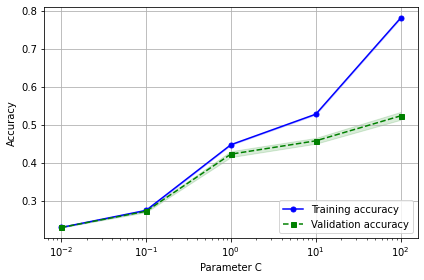

In [8]:
svm = SVC(random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
param_range = [0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
                estimator=svm, 
                X=X_train, 
                y=y_train, 
                param_name='C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

## K-fold cross-validation

In [9]:
svm = SVC(C=10.0, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')
scores = cross_val_score(estimator=svm,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.44592875 0.47423664 0.45625199 0.45466115 0.45402482 0.46516067
 0.46134267 0.45561565 0.45688832 0.44957047]
CV accuracy: 0.457 +/- 0.008


# Visualizing learning curves

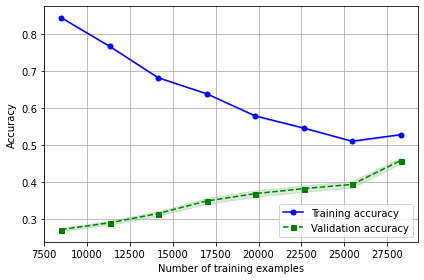

In [7]:
svm = SVC(C=10.0, random_state=1, kernel='rbf', gamma='auto', decision_function_shape='ovo')

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=svm,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()